In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import GridWorld_env
import gymnasium as gym
import random

In [2]:
class Conv_NN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(Conv_NN, self).__init__()
        self.conv1 = nn.Conv3d(3, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm3d(64)
        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm3d(64)
        
        self.fc1 = nn.Linear(64*input_dim * input_dim * input_dim, action_dim)
    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x) + x))
        x = F.relu(self.batchnorm3(self.conv3(x) + x))
        x = nn.Flatten()(x)
        x = self.fc1(x)
        return x

new_env = gym.make('GridWorld_env/GridWorld', dimension_size=4)
test = Conv_NN(4, 7)
new_env.reset()
state, _, _, _, _ = new_env.step(0)
state = torch.tensor(state).float()

import torchinfo
torchinfo.summary(test, (8, 3, 4, 4, 4))

1 200 False


c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:228: UserWarning: WARN: Expects `terminated` signal to be a boolean, actual type: <class 'torch.Tensor'>
  logger.warn(
c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:232: UserWarning: WARN: Expects `truncated` signal to be a boolean, actual type: <class 'torch.Tensor'>
  logger.warn(
c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'torch.Tensor'>
  logger.warn(


Layer (type:depth-idx)                   Output Shape              Param #
Conv_NN                                  [8, 7]                    --
├─Conv3d: 1-1                            [8, 64, 4, 4, 4]          5,248
├─BatchNorm3d: 1-2                       [8, 64, 4, 4, 4]          128
├─Conv3d: 1-3                            [8, 64, 4, 4, 4]          110,656
├─BatchNorm3d: 1-4                       [8, 64, 4, 4, 4]          128
├─Conv3d: 1-5                            [8, 64, 4, 4, 4]          110,656
├─BatchNorm3d: 1-6                       [8, 64, 4, 4, 4]          128
├─Linear: 1-7                            [8, 7]                    28,679
Total params: 255,623
Trainable params: 255,623
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 116.23
Input size (MB): 0.01
Forward/backward pass size (MB): 1.57
Params size (MB): 1.02
Estimated Total Size (MB): 2.60

In [3]:
def deep_Q_learning():
    # Initialised replay buffer
    replay_buffer = []
    gamma = 0.995
    # Intialised Q network
    Q_network = Conv_NN(4, 7)
    optimizer = optim.SGD(Q_network.parameters(), lr=0.0005, momentum=0.9)
    EPISODES = 10
    # Loop over episodes
    for episode in range(EPISODES):
        
        # Reset environment
        new_env.reset()
        
        # Loop over steps
        for timestep in range(300):
            # Get state
            Q_network.zero_grad()
            state = new_env.unwrapped.get_obs()
            state = torch.tensor(state).unsqueeze(0).float()
            
            q_values = Q_network(state)
            
            # Episilon greedy policy
            if random.random() > 0.1:
                action = torch.argmax(q_values)
            else:
                action = torch.randint(0, 7, (1,))[0]
               
            
            
            next_state, reward, done, truncated, _ = new_env.step(action)
            
            replay_buffer.append((state.squeeze(0), action, reward, next_state, done))
            
            minibatch = random.choices(replay_buffer, k=32)
            # Form minibatch
            batch_state = torch.stack([i[0] for i in minibatch])
            batch_action = torch.stack([i[1] for i in minibatch])
            batch_reward = torch.stack([i[2] for i in minibatch])
            batch_next_state = torch.stack([torch.tensor(i[3]).float() for i in minibatch])
            batch_done = torch.stack([i[4] for i in minibatch])
            
            
            # Form target y by boostrapping
            target_y = batch_reward.float() + gamma * torch.max(Q_network(batch_next_state).detach(), dim=1)[0] * (1 - batch_done.float())
            target_y.requires_grad = False
            
            y_hat = Q_network(batch_state).gather(1, batch_action.unsqueeze(0).T.repeat(1, 7))[:, 0]
            
            loss = F.mse_loss(y_hat, target_y)
            loss.backward()
            optimizer.step()
            
            if timestep % 1 == 0:
                print(f"Episode: {episode}, Timestep: {timestep}, Loss: {loss.item()}, timestep: {new_env.unwrapped.timestep_elapsed}")
                
            
            if done == 1 or truncated == 1:
                new_env.unwrapped.render()
                break
    
            
            
        

1 200 False
Episode: 0, Timestep: 0, Loss: 1.012161135673523, timestep: 1
2 200 False
Episode: 0, Timestep: 1, Loss: 1.5239697694778442, timestep: 2
3 200 False
Episode: 0, Timestep: 2, Loss: 2.8668768405914307, timestep: 3
4 200 False
Episode: 0, Timestep: 3, Loss: 0.6649749875068665, timestep: 4
5 200 False
Episode: 0, Timestep: 4, Loss: 1.2066733837127686, timestep: 5
6 200 False
Episode: 0, Timestep: 5, Loss: 0.8977575898170471, timestep: 6
7 200 False
Episode: 0, Timestep: 6, Loss: 0.5567021369934082, timestep: 7
8 200 False
Episode: 0, Timestep: 7, Loss: 1.1286883354187012, timestep: 8
9 200 False
Episode: 0, Timestep: 8, Loss: 625.6632080078125, timestep: 9
10 200 False
Episode: 0, Timestep: 9, Loss: 204.88522338867188, timestep: 10
11 200 False
Episode: 0, Timestep: 10, Loss: 417.6771240234375, timestep: 11
12 200 False
Episode: 0, Timestep: 11, Loss: 15.01418685913086, timestep: 12
13 200 False
Episode: 0, Timestep: 12, Loss: 48.642311096191406, timestep: 13
14 200 False
Episo

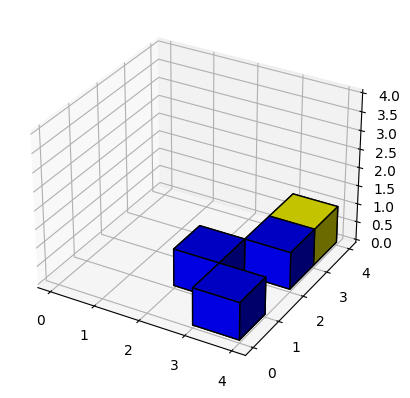

1 200 False
Episode: 1, Timestep: 0, Loss: 2.8305022716522217, timestep: 1
2 200 False
Episode: 1, Timestep: 1, Loss: 2.6998088359832764, timestep: 2
3 200 False
Episode: 1, Timestep: 2, Loss: 1.3362842798233032, timestep: 3
4 200 False
Episode: 1, Timestep: 3, Loss: 3.337960720062256, timestep: 4
5 200 False
Episode: 1, Timestep: 4, Loss: 2.7119672298431396, timestep: 5
6 200 False
Episode: 1, Timestep: 5, Loss: 0.8992880582809448, timestep: 6
7 200 False
Episode: 1, Timestep: 6, Loss: 0.4233444035053253, timestep: 7
8 200 False
Episode: 1, Timestep: 7, Loss: 0.6090783476829529, timestep: 8
9 200 False
Episode: 1, Timestep: 8, Loss: 94.94108581542969, timestep: 9
10 200 False
Episode: 1, Timestep: 9, Loss: 2.7582404613494873, timestep: 10
11 200 False
Episode: 1, Timestep: 10, Loss: 25.550029754638672, timestep: 11
12 200 False
Episode: 1, Timestep: 11, Loss: 65.98253631591797, timestep: 12
13 200 False
Episode: 1, Timestep: 12, Loss: 3.729259967803955, timestep: 13
14 200 False
Episo

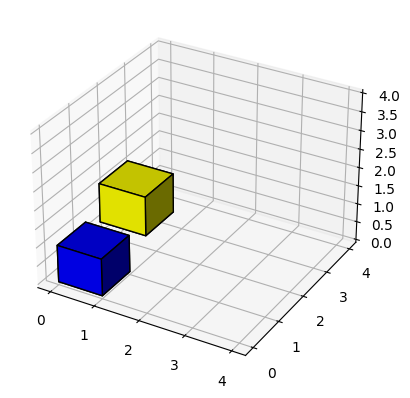

1 200 False
Episode: 2, Timestep: 0, Loss: 2.969916343688965, timestep: 1
2 200 False
Episode: 2, Timestep: 1, Loss: 8.465757369995117, timestep: 2
3 200 False
Episode: 2, Timestep: 2, Loss: 3.7749624252319336, timestep: 3
4 200 False
Episode: 2, Timestep: 3, Loss: 29.247819900512695, timestep: 4
5 200 False
Episode: 2, Timestep: 4, Loss: 0.9999451637268066, timestep: 5
6 200 False
Episode: 2, Timestep: 5, Loss: 7.552046775817871, timestep: 6
7 200 False
Episode: 2, Timestep: 6, Loss: 3.582875967025757, timestep: 7
8 200 False
Episode: 2, Timestep: 7, Loss: 1.0124949216842651, timestep: 8
9 200 False
Episode: 2, Timestep: 8, Loss: 4.3962931632995605, timestep: 9
10 200 False
Episode: 2, Timestep: 9, Loss: 26.106077194213867, timestep: 10
11 200 False
Episode: 2, Timestep: 10, Loss: 1.788556456565857, timestep: 11
12 200 False
Episode: 2, Timestep: 11, Loss: 3.9422409534454346, timestep: 12
13 200 False
Episode: 2, Timestep: 12, Loss: 2.156268835067749, timestep: 13
14 200 False
Episode

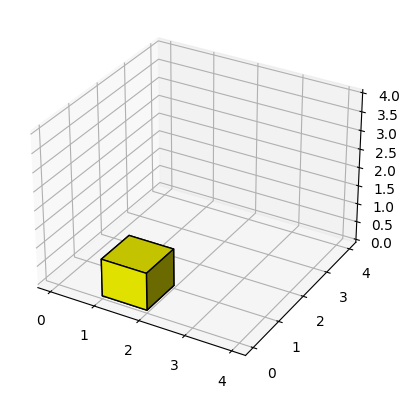

1 200 False
Episode: 3, Timestep: 0, Loss: 0.471767395734787, timestep: 1
2 200 False
Episode: 3, Timestep: 1, Loss: 0.9212444424629211, timestep: 2
3 200 False
Episode: 3, Timestep: 2, Loss: 0.3974144756793976, timestep: 3
4 200 False
Episode: 3, Timestep: 3, Loss: 9.72128677368164, timestep: 4
5 200 False
Episode: 3, Timestep: 4, Loss: 0.20212706923484802, timestep: 5
6 200 False
Episode: 3, Timestep: 5, Loss: 0.20532158017158508, timestep: 6
7 200 False
Episode: 3, Timestep: 6, Loss: 0.4735026955604553, timestep: 7
8 200 False
Episode: 3, Timestep: 7, Loss: 0.6644431352615356, timestep: 8
9 200 False
Episode: 3, Timestep: 8, Loss: 0.25640133023262024, timestep: 9
10 200 False
Episode: 3, Timestep: 9, Loss: 0.4057055711746216, timestep: 10
11 200 False
Episode: 3, Timestep: 10, Loss: 1.172337532043457, timestep: 11
12 200 False
Episode: 3, Timestep: 11, Loss: 0.3934335708618164, timestep: 12
13 200 False
Episode: 3, Timestep: 12, Loss: 1.022391438484192, timestep: 13
14 200 False
Epi

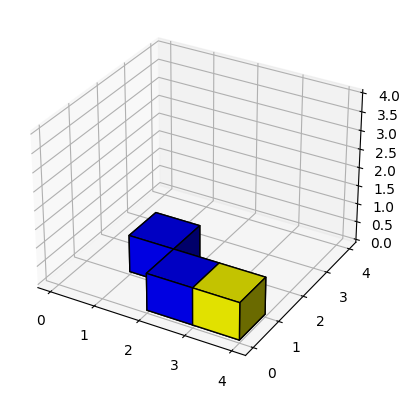

1 200 False
Episode: 4, Timestep: 0, Loss: 1.3726156949996948, timestep: 1
2 200 False
Episode: 4, Timestep: 1, Loss: 0.5207042694091797, timestep: 2
3 200 False
Episode: 4, Timestep: 2, Loss: 1.5014100074768066, timestep: 3
4 200 False
Episode: 4, Timestep: 3, Loss: 4.850883960723877, timestep: 4
5 200 False
Episode: 4, Timestep: 4, Loss: 11.364425659179688, timestep: 5
6 200 False
Episode: 4, Timestep: 5, Loss: 0.8713263273239136, timestep: 6
7 200 False
Episode: 4, Timestep: 6, Loss: 0.5308228135108948, timestep: 7
8 200 False
Episode: 4, Timestep: 7, Loss: 0.5917576551437378, timestep: 8
9 200 False
Episode: 4, Timestep: 8, Loss: 1.0411309003829956, timestep: 9
10 200 False
Episode: 4, Timestep: 9, Loss: 0.9773370027542114, timestep: 10
11 200 False
Episode: 4, Timestep: 10, Loss: 3.180785894393921, timestep: 11
12 200 False
Episode: 4, Timestep: 11, Loss: 0.8781055808067322, timestep: 12
13 200 False
Episode: 4, Timestep: 12, Loss: 0.8701761960983276, timestep: 13
14 200 False
Epi

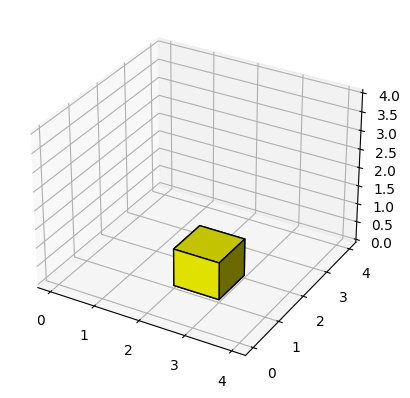

1 200 False
Episode: 5, Timestep: 0, Loss: 0.7727447152137756, timestep: 1
2 200 False
Episode: 5, Timestep: 1, Loss: 1.1269948482513428, timestep: 2
3 200 False
Episode: 5, Timestep: 2, Loss: 0.7724664807319641, timestep: 3
4 200 False
Episode: 5, Timestep: 3, Loss: 4.521524906158447, timestep: 4
5 200 False
Episode: 5, Timestep: 4, Loss: 0.8799597024917603, timestep: 5
6 200 False
Episode: 5, Timestep: 5, Loss: 1.1986373662948608, timestep: 6
7 200 False
Episode: 5, Timestep: 6, Loss: 1.2179099321365356, timestep: 7
8 200 False
Episode: 5, Timestep: 7, Loss: 0.8228598833084106, timestep: 8
9 200 False
Episode: 5, Timestep: 8, Loss: 0.6932152509689331, timestep: 9
10 200 False
Episode: 5, Timestep: 9, Loss: 0.6351907253265381, timestep: 10
11 200 False
Episode: 5, Timestep: 10, Loss: 4.166667938232422, timestep: 11
12 200 False
Episode: 5, Timestep: 11, Loss: 0.567919135093689, timestep: 12
13 200 False
Episode: 5, Timestep: 12, Loss: 0.9375605583190918, timestep: 13
14 200 False
Epis

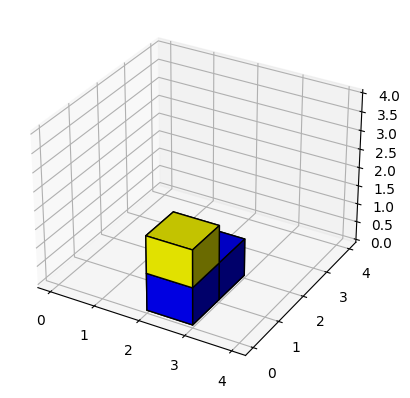

1 200 False
Episode: 6, Timestep: 0, Loss: 1.3009119033813477, timestep: 1
2 200 False
Episode: 6, Timestep: 1, Loss: 2.1979317665100098, timestep: 2
3 200 False
Episode: 6, Timestep: 2, Loss: 0.499127596616745, timestep: 3
4 200 False
Episode: 6, Timestep: 3, Loss: 0.4405737817287445, timestep: 4
5 200 False
Episode: 6, Timestep: 4, Loss: 0.4156893193721771, timestep: 5
6 200 False
Episode: 6, Timestep: 5, Loss: 0.3363915681838989, timestep: 6
7 200 False
Episode: 6, Timestep: 6, Loss: 0.5174937844276428, timestep: 7
8 200 False
Episode: 6, Timestep: 7, Loss: 0.7027594447135925, timestep: 8
9 200 False
Episode: 6, Timestep: 8, Loss: 1.846637487411499, timestep: 9
10 200 False
Episode: 6, Timestep: 9, Loss: 0.6073606014251709, timestep: 10
11 200 False
Episode: 6, Timestep: 10, Loss: 0.3782012164592743, timestep: 11
12 200 False
Episode: 6, Timestep: 11, Loss: 0.5225335955619812, timestep: 12
13 200 False
Episode: 6, Timestep: 12, Loss: 2.1045284271240234, timestep: 13
14 200 False
Epi

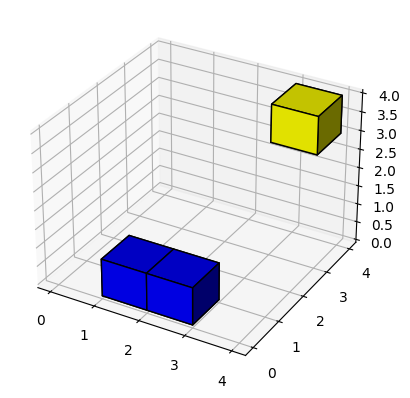

1 200 False
Episode: 7, Timestep: 0, Loss: nan, timestep: 1
2 200 False
Episode: 7, Timestep: 1, Loss: nan, timestep: 2
3 200 False
Episode: 7, Timestep: 2, Loss: nan, timestep: 3
4 200 False
Episode: 7, Timestep: 3, Loss: nan, timestep: 4
5 200 False
Episode: 7, Timestep: 4, Loss: nan, timestep: 5
6 200 False
Episode: 7, Timestep: 5, Loss: nan, timestep: 6
7 200 False
Episode: 7, Timestep: 6, Loss: nan, timestep: 7
8 200 False
Episode: 7, Timestep: 7, Loss: nan, timestep: 8
9 200 False
Episode: 7, Timestep: 8, Loss: nan, timestep: 9
10 200 False
Episode: 7, Timestep: 9, Loss: nan, timestep: 10
11 200 False
Episode: 7, Timestep: 10, Loss: nan, timestep: 11
12 200 False
Episode: 7, Timestep: 11, Loss: nan, timestep: 12
13 200 False
Episode: 7, Timestep: 12, Loss: nan, timestep: 13
14 200 False
Episode: 7, Timestep: 13, Loss: nan, timestep: 14
15 200 False
Episode: 7, Timestep: 14, Loss: nan, timestep: 15
16 200 False
Episode: 7, Timestep: 15, Loss: nan, timestep: 16
17 200 False
Episode

KeyboardInterrupt: 

In [4]:
deep_Q_learning()

In [ ]:
Q_network

NameError: name 'Q_network' is not defined